<a href="https://colab.research.google.com/github/tsholofelo-mokheleli/xAI-gender-based-mental-health-analysis/blob/main/age-mental-model-development-xai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Development**

In [1]:
# Load the librarys
import pandas  as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import psutil
import os

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# Data split
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score
from imblearn.metrics import geometric_mean_score

# Class Imbalance
from imblearn.over_sampling import SMOTE

# Classifiers
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Hyper-parameter tuning
from sklearn.model_selection import GridSearchCV

# Cross Validation
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import clone

# xAI
import shap

In [2]:
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 600,
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.titlesize": 12,
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})
sns.set_style("white")
sns.set_context("paper", font_scale=1.2)

export_png = True

out_dir = "figures"
os.makedirs(out_dir, exist_ok=True)

def safe_name(s: str) -> str:
    return "".join(c if (c.isalnum() or c in "-_") else "_" for c in s).strip("_")

### **Load dataset**

In [3]:
data = pd.read_csv("final_dataset.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2163 entries, 0 to 2162
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                2163 non-null   int64  
 1   Gender                             2163 non-null   int64  
 2   Self_employed                      2163 non-null   int64  
 3   Company_size                       2163 non-null   int64  
 4   Mh_benefits                        2163 non-null   int64  
 5   Employer_discussed_mh              2163 non-null   int64  
 6   Mh_resources                       2163 non-null   int64  
 7   Anonymity_protected                2163 non-null   int64  
 8   Ease_medical_leave                 2163 non-null   int64  
 9   Comfort_coworkers                  2163 non-null   int64  
 10  Comfort_supervisor                 2163 non-null   int64  
 11  Employer_importance_mental         2163 non-null   int64

In [5]:
data.shape

(2163, 20)

### **Stratified Training**

When we split the data into Training and Testing sets, we must ensure both sets have the exact same proportion of Men/Women and Diagnosed/Not-Diagnosed as the original.

In [6]:
data['stratify_col'] = data['Gender'].astype(str) + "_" + data['Diagnosed_mh'].astype(str)

X = data.drop(['Diagnosed_mh', 'stratify_col'], axis=1)
y = data['Diagnosed_mh']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=data['stratify_col'], random_state=42
)

### **Calculate Class Weights**

$$Scale\ Pos\ Weight = \frac{\sum Negative\ Instances}{\sum Positive\ Instances}$$

In [7]:
counts = y_train.value_counts()
count_neg = counts.get(0, 0)
count_pos = counts.get(1, 0)

if count_pos > 0:
    xgb_scale_pos_weight = count_neg / count_pos
else:
    xgb_scale_pos_weight = 1.0

*To address class imbalance within the training set, the XGBoost classifier's $scale\_pos\_weight$ was dynamically set to the ratio of the majority to minority class ($N_{negative} / N_{positive}$). This ensures the model's loss function is appropriately weighted to penalize misclassifications of the 'Diagnosed' group, thereby improving the sensitivity of the gender-stratified analysis.*

### **Define models**

In [8]:
classifiers = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        solver='liblinear'
    ),
    "Random Forest": RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=xgb_scale_pos_weight,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
}

### **Hyperparameter Tuning**

In [9]:
param_grid = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    },
    "Random Forest": {
        'n_estimators': [100, 200, 500],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    "XGBoost": {
        'max_depth': [3, 6, 9],
        'learning_rate': [0.1, 0.01, 0.001],
        'n_estimators': [100, 500, 1000]
    }
}

In [10]:
best_params = {}

for name, clf in classifiers.items():
    if name in param_grid:
        print(f"Starting GridSearch for {name}...")

        grid_search = GridSearchCV(
            estimator=clf,
            param_grid=param_grid[name],
            cv=5,
            scoring='balanced_accuracy',
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)
        best_params[name] = grid_search.best_params_
        print(f"Done. Best score for {name}: {grid_search.best_score_:.4f}")

Starting GridSearch for Logistic Regression...
Done. Best score for Logistic Regression: 0.6916
Starting GridSearch for Random Forest...
Done. Best score for Random Forest: 0.7709
Starting GridSearch for XGBoost...
Done. Best score for XGBoost: 0.7796


### **Best Params**

In [11]:
print("\n" + "="*50)
print("FINAL OPTIMIZED HYPERPARAMETERS")
print("="*50)

for model_name, params in best_params.items():
    print(f"\n>>> {model_name}:")
    for param_name, value in params.items():
        print(f"    - {param_name:20}: {value}")

print("\n" + "="*50)


FINAL OPTIMIZED HYPERPARAMETERS

>>> Logistic Regression:
    - C                   : 0.1
    - penalty             : l1

>>> Random Forest:
    - max_depth           : 10
    - min_samples_split   : 5
    - n_estimators        : 200

>>> XGBoost:
    - learning_rate       : 0.1
    - max_depth           : 3
    - n_estimators        : 100



### **Model Implementation**

In [13]:
results = {}

for name, clf in classifiers.items():
    best_param = best_params.get(name)

    if best_param:
        clf = clf.set_params(**best_param)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        geometric_mean = geometric_mean_score(y_test, y_pred)

        results[name] = {
            "Balanced Accuracy": balanced_accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Geometric Mean": geometric_mean,
        }


metrics_df = pd.DataFrame(results).T
display(metrics_df.reset_index().rename(columns={"index": "Classifier"}))

,Classifier,Balanced Accuracy,Precision,Recall,F1 Score,Geometric Mean
0,Logistic Regression,0.713881,0.827309,0.720280,0.770093,0.713853
1,Random Forest,0.793825,0.864286,0.846154,0.855124,0.792099
2,XGBoost,0.784513,0.875486,0.786713,0.828729,0.784510


### **Results Visuals**

Classifier Performance Comparison


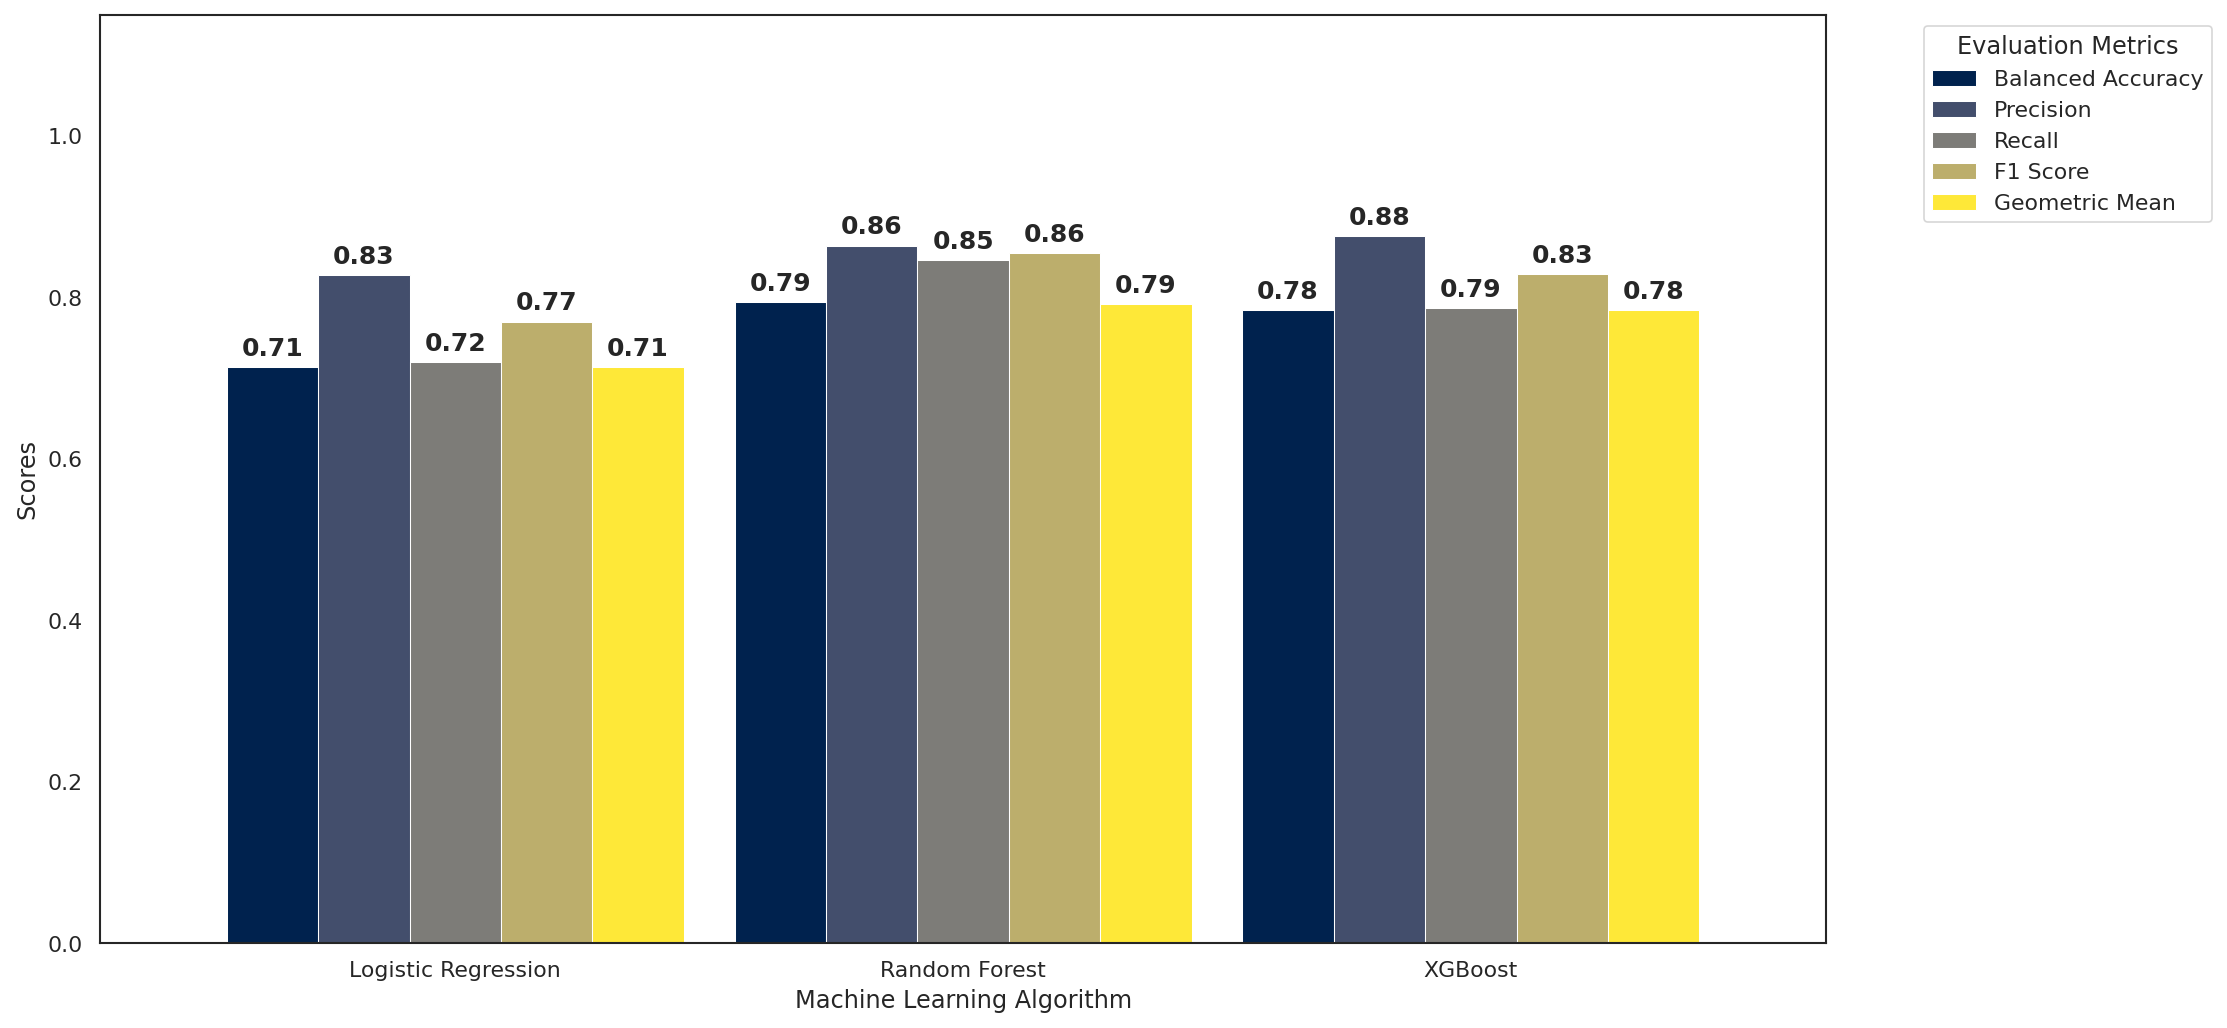

In [14]:
plot_df = metrics_df

fig, ax = plt.subplots(figsize=(15, 7))

plot_df.plot(kind="bar", ax=ax, cmap="cividis", edgecolor='white', linewidth=0.5, width=0.9)

for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.2f',
        padding=3,
        fontsize=12,
        fontweight='bold'
    )

print("Classifier Performance Comparison")
ax.set_ylabel("Scores")
ax.set_xlabel("Machine Learning Algorithm")
ax.set_ylim(0, 1.15)
plt.xticks(rotation=0)
plt.legend(title='Evaluation Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

base_name = "classifier_performance_results"
pdf_path = os.path.join(out_dir, f"{base_name}.pdf")
fig.savefig(pdf_path, bbox_inches="tight", pad_inches=0.02)

plt.show()
plt.close(fig)

### **Male vs. Female**

In [15]:
subgroups = {
    "Male": (X_test['Gender'] == 1),
    "Female": (X_test['Gender'] == 0)
}

final_gender_metrics = {}

for gender_name, mask in subgroups.items():
    results = {}

    X_sub = X_test[mask]
    y_sub = y_test[mask]

    for name, clf in classifiers.items():
        best_param = best_params.get(name)

        if best_param:
            clf = clf.set_params(**best_param)

            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_sub)

            balanced_accuracy = balanced_accuracy_score(y_sub, y_pred)
            precision = precision_score(y_sub, y_pred)
            recall = recall_score(y_sub, y_pred)
            f1 = f1_score(y_sub, y_pred)
            geometric_mean = geometric_mean_score(y_sub, y_pred)

            results[name] = {
                "Balanced Accuracy": balanced_accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1,
                "Geometric Mean": geometric_mean,
            }


    df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Classifier"})
    final_gender_metrics[gender_name] = df

for gender_name, df in final_gender_metrics.items():
    print(f"\n--- {gender_name} Results ---")
    display(df)
    print("\n")


--- Male Results ---


,Classifier,Balanced Accuracy,Precision,Recall,F1 Score,Geometric Mean
0,Logistic Regression,0.697799,0.813433,0.602210,0.692063,0.691221
1,Random Forest,0.783457,0.841176,0.790055,0.814815,0.783430
2,XGBoost,0.775102,0.861842,0.723757,0.786787,0.773399





--- Female Results ---


,Classifier,Balanced Accuracy,Precision,Recall,F1 Score,Geometric Mean
0,Logistic Regression,0.615751,0.843478,0.923810,0.881818,0.533150
1,Random Forest,0.759890,0.900000,0.942857,0.920930,0.737534
2,XGBoost,0.736081,0.895238,0.895238,0.895238,0.718668


### **Cross Validation**

In [16]:
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [17]:
train_subgroups = {
    "Overall": None,
    "Male": (X_train['Gender'] == 1),
    "Female": (X_train['Gender'] == 0)
}

final_cv_results = {}

for subgroup_name, mask in train_subgroups.items():
    subgroup_metrics = {}

    if mask is not None:
        X_cv = X_train[mask]
        y_cv = y_train[mask]
    else:
        X_cv = X_train
        y_cv = y_train

    for name, clf in classifiers.items():
        best_param = best_params.get(name)

        if best_param:
            clf = clf.set_params(**best_param)

            cv_scores = cross_val_score(clf, X_cv, y_cv, cv=kfold, scoring='balanced_accuracy')

            subgroup_metrics[name] = {
                "Mean Balanced Acc": np.mean(cv_scores),
                "Std Dev": np.std(cv_scores)
            }

    final_cv_results[subgroup_name] = pd.DataFrame(subgroup_metrics).T

for subgroup_name, df in final_cv_results.items():
    print(f"\n--- {subgroup_name} Cross-Validation Results ---")
    display(df.style.format("{:.4f}"))


--- Overall Cross-Validation Results ---


,Mean Balanced Acc,Std Dev
Logistic Regression,0.6895,0.0237
Random Forest,0.7691,0.0198
XGBoost,0.7856,0.0252



--- Male Cross-Validation Results ---


,Mean Balanced Acc,Std Dev
Logistic Regression,0.6726,0.0207
Random Forest,0.7627,0.0179
XGBoost,0.7637,0.0278



--- Female Cross-Validation Results ---


,Mean Balanced Acc,Std Dev
Logistic Regression,0.6567,0.0507
Random Forest,0.6412,0.0362
XGBoost,0.6860,0.0406


### **Explainable Artificial Intelligence**

**The Decision: Random Forest (RF) is your "Analysis Model"**


### **Initialize the SHAP Explainer**

In [18]:
shap.initjs()

In [19]:
best_rf = RandomForestClassifier(**best_params["Random Forest"])
best_rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200)

In [20]:
# 2. Initialize the TreeExplainer (Optimized for Random Forest)
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

shap_obj = shap_values[:,:,1]

### **Generate Overall SHAP Summaries**

**Beeswarm plot**

Global Predictors of Mental Health Diagnosis (Total Population)


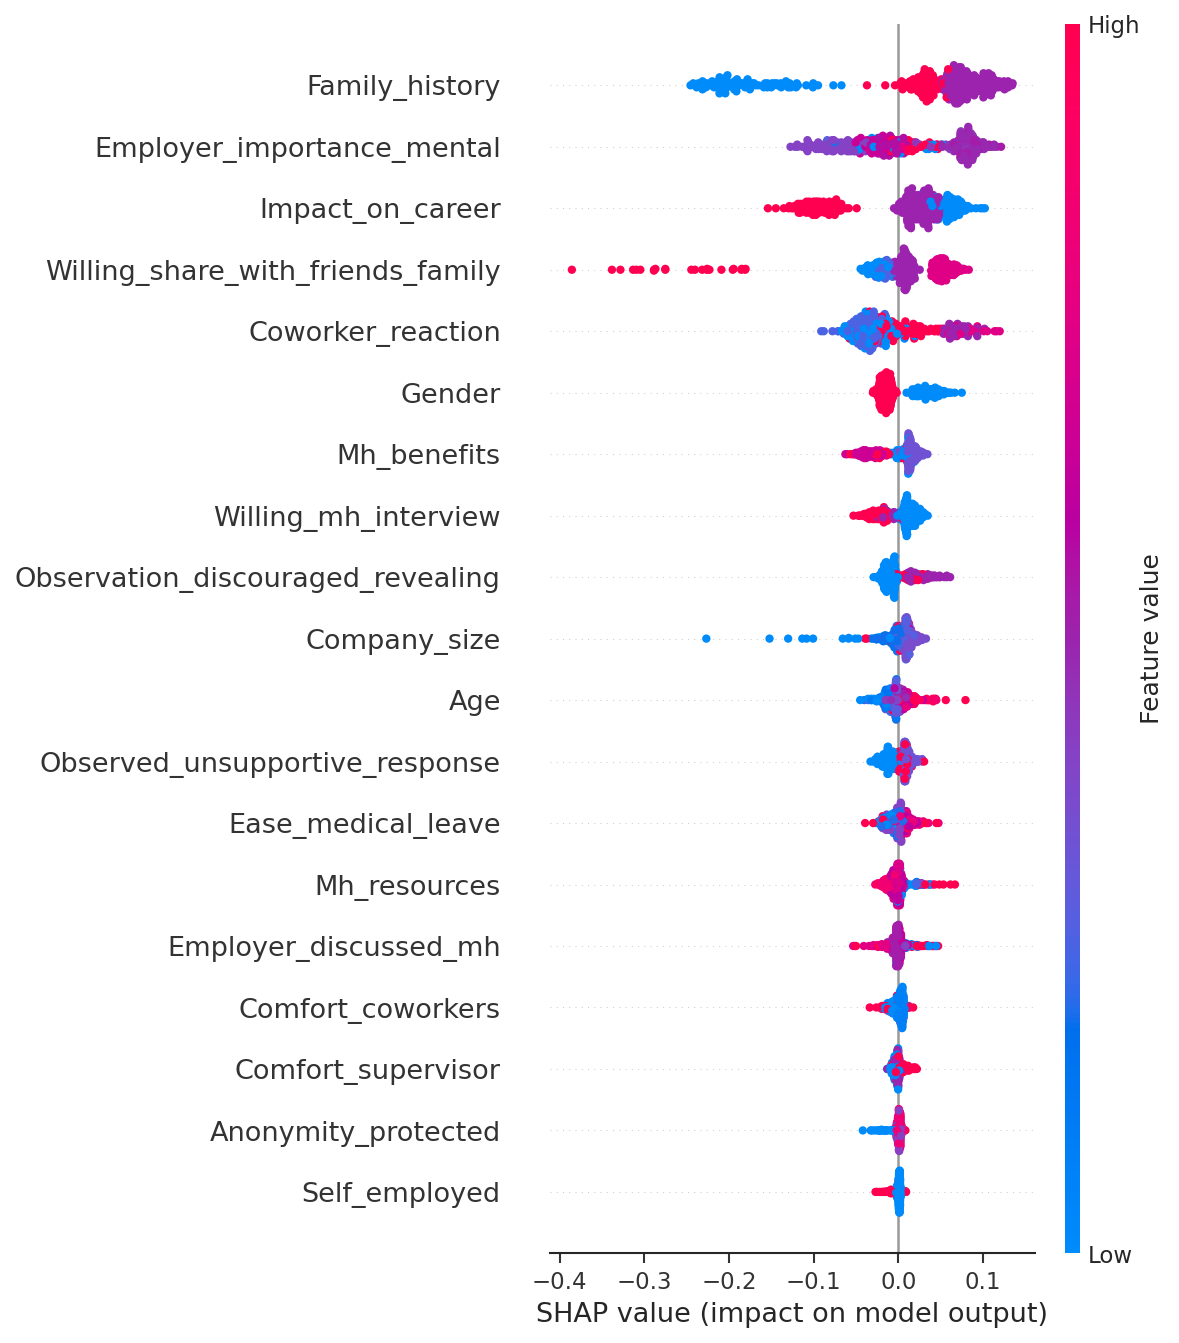

In [21]:
plt.figure(figsize=(12, 8))

shap.summary_plot(
    shap_obj,
    X_test,
    plot_type="dot",
    feature_names=X_test.columns.tolist(),
    show=False
)

print("Global Predictors of Mental Health Diagnosis (Total Population)")

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_summary_overall.pdf"), bbox_inches='tight')
plt.show()

### **Overall Feature Importance**

Global Feature Importance: All Respondents
(Mean Absolute SHAP Value)


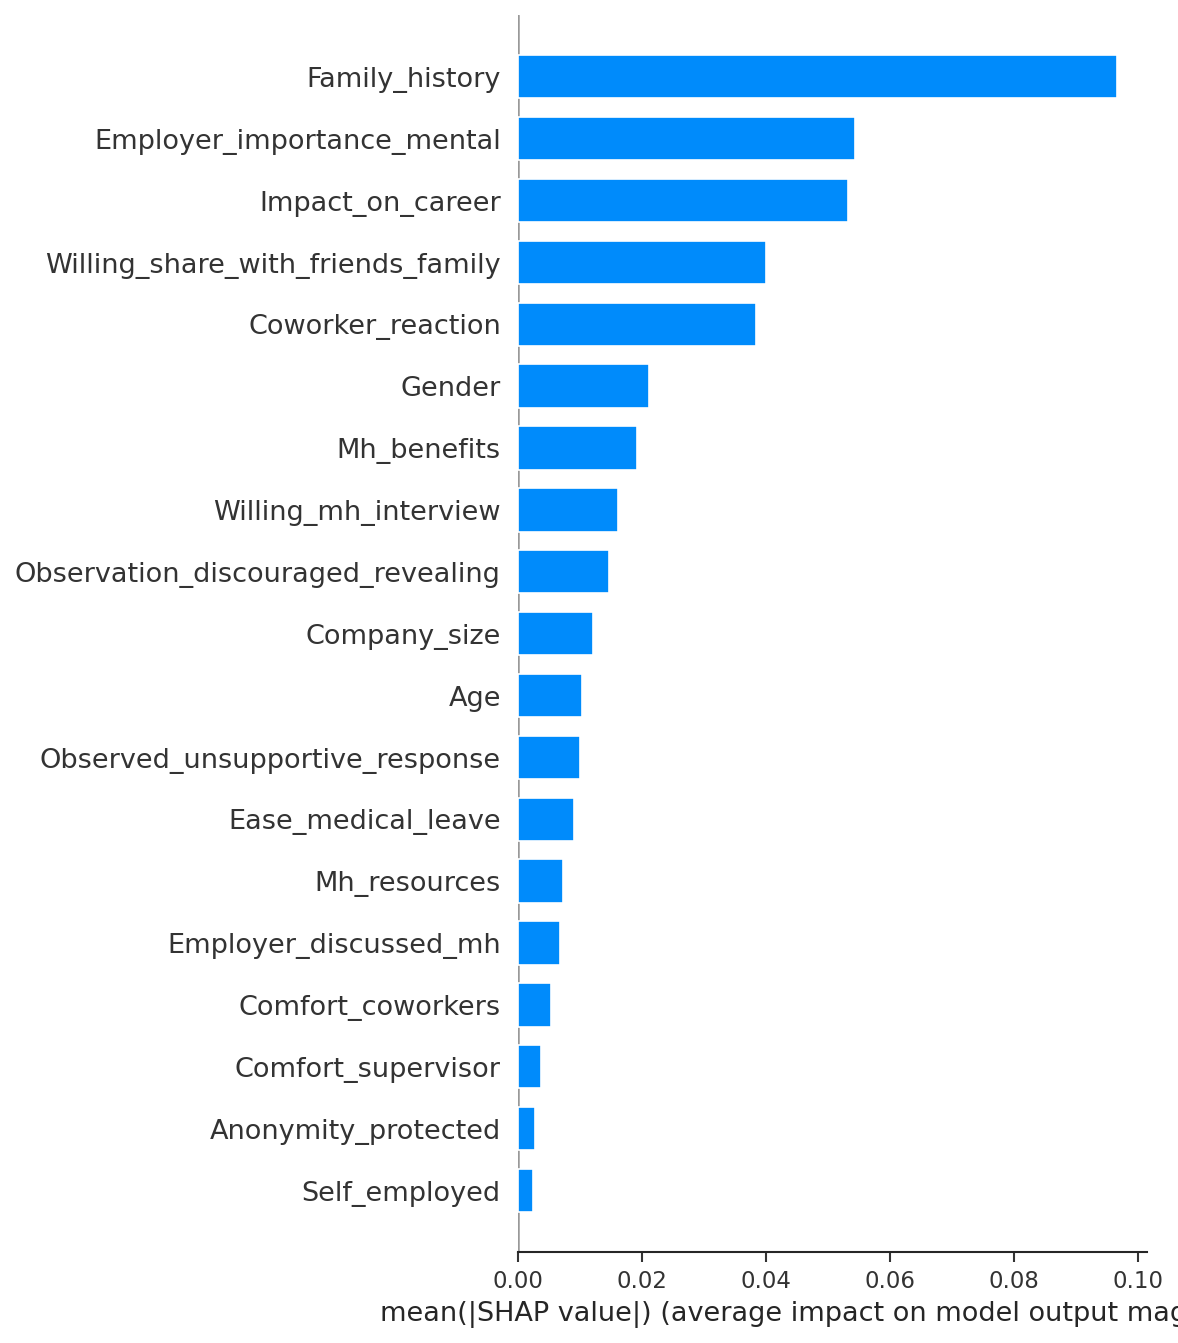

In [22]:
# --- Overall Plot (Mean Absolute SHAP) ---
plt.figure(figsize=(10, 6))

shap.summary_plot(
    shap_obj,
    X_test,
    plot_type="bar",
    show=False
)

print("Global Feature Importance: All Respondents\n(Mean Absolute SHAP Value)")

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_bar_overall.pdf"), bbox_inches='tight')
plt.show()

### **Generate Gender-Specific SHAP Summaries**

**Beeswarm plot**

Top Predictors of Mental Health Diagnosis (Male Respondents)


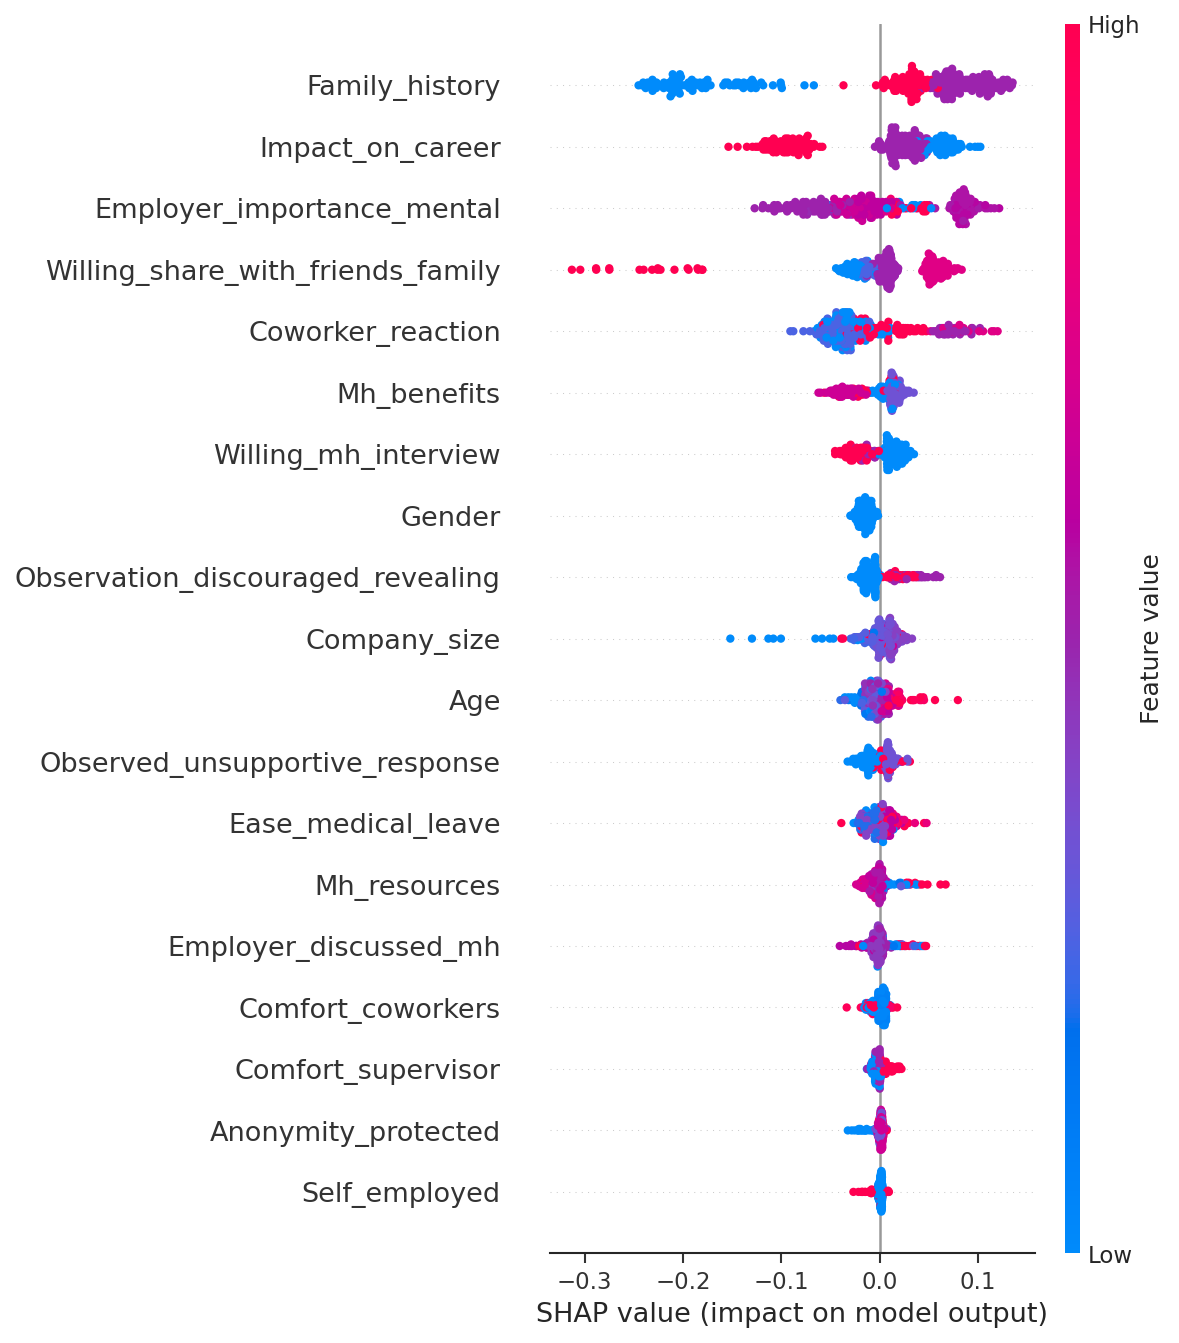

Top Predictors of Mental Health Diagnosis (Female Respondents)


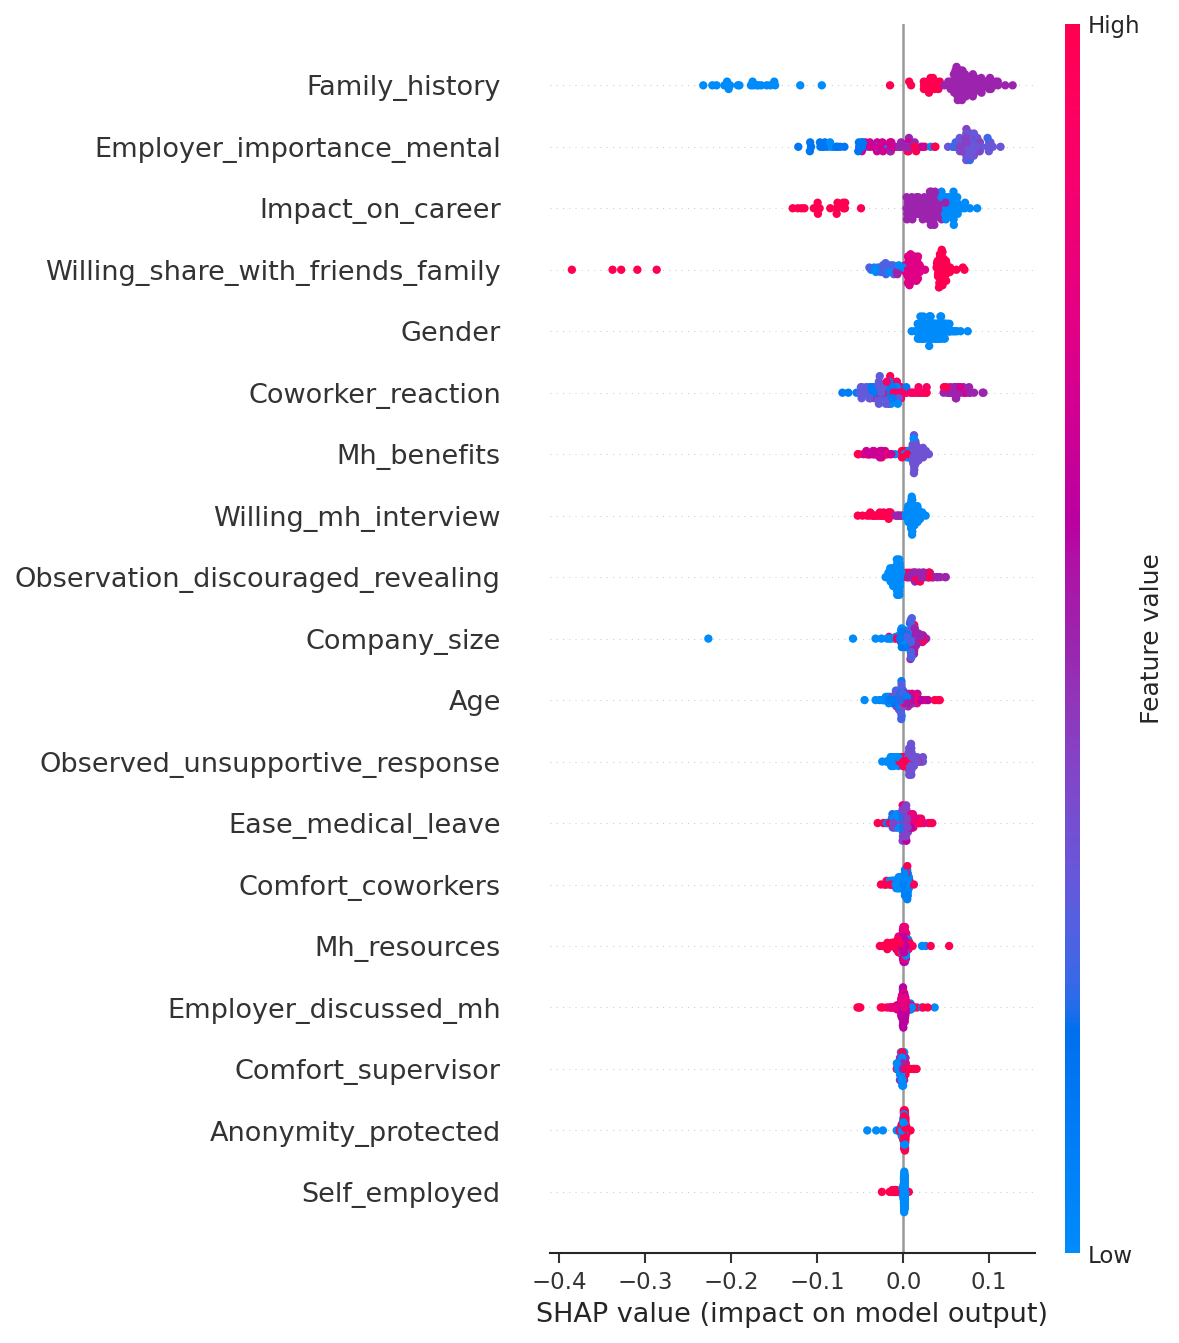

In [23]:
male_mask = (X_test['Gender'] == 1).values
female_mask = (X_test['Gender'] == 0).values

# Plot for Men
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_obj[male_mask],
    X_test[male_mask],
    plot_type="dot",
    feature_names=X_test.columns.tolist(),
    show=False,
    )

print("Top Predictors of Mental Health Diagnosis (Male Respondents)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_summary_male.pdf"))
plt.show()

# Plot for Women
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_obj[female_mask],
    X_test[female_mask],
    plot_type="dot",
    feature_names=X_test.columns.tolist(),
    show=False,
    )
print("Top Predictors of Mental Health Diagnosis (Female Respondents)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_summary_female.pdf"))
plt.show()

### **Gender-Specific Feature Importance**

Top Global Predictors: Male Respondents
(Mean Absolute SHAP Value)


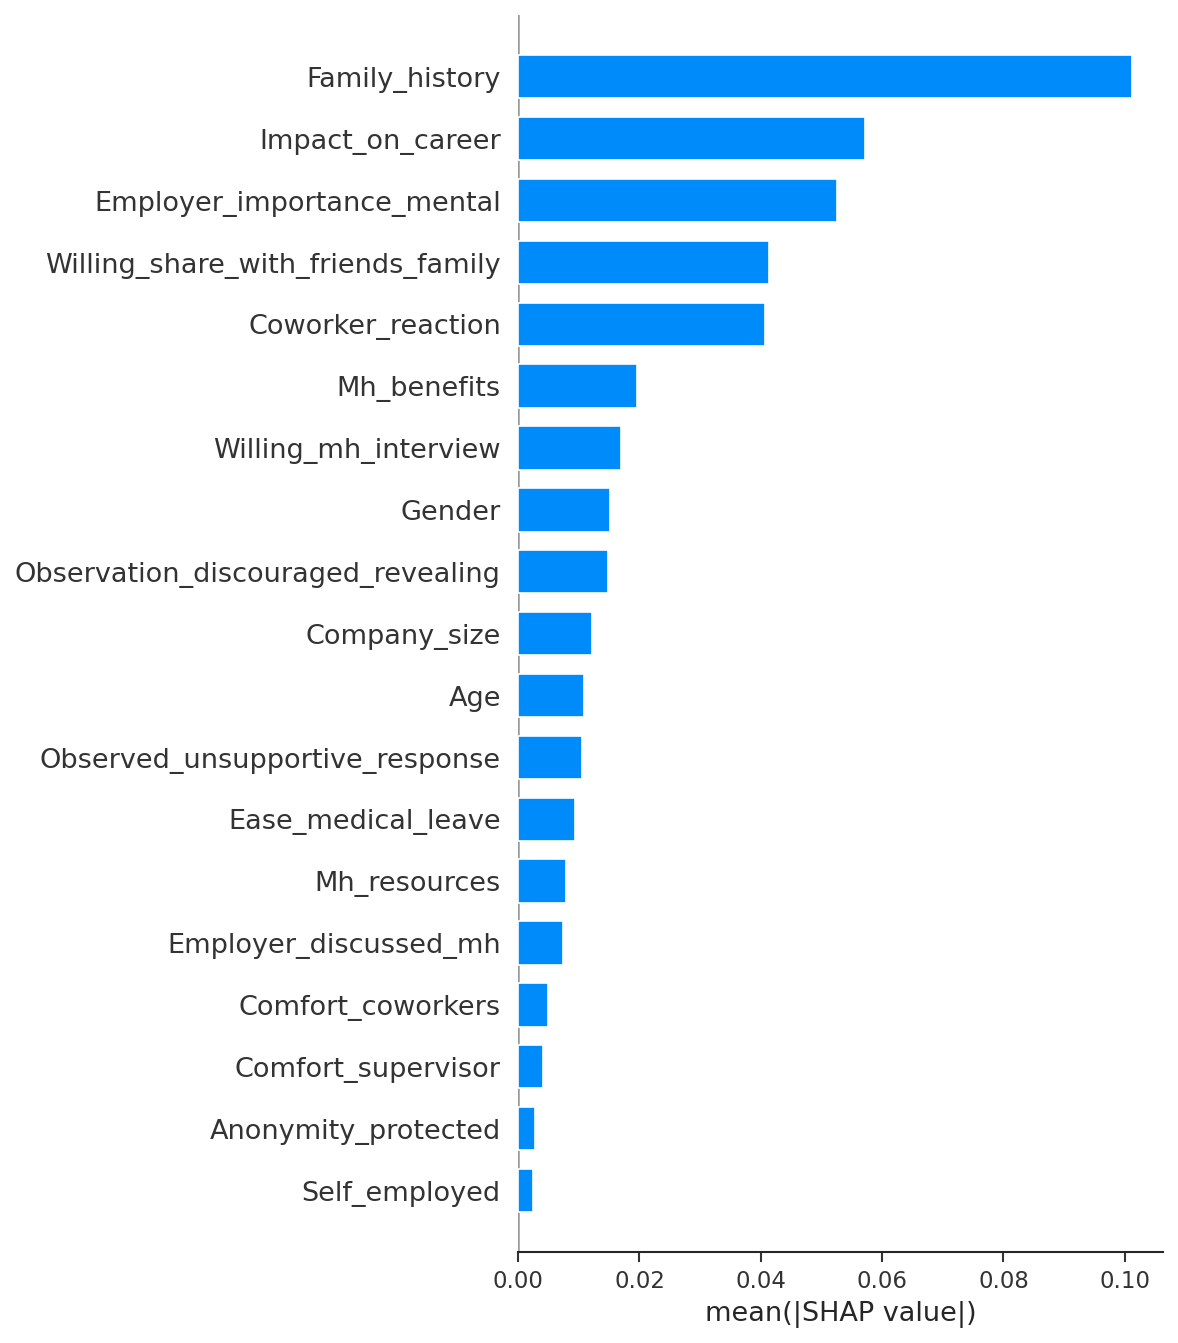

Top Global Predictors: Female Respondents
(Mean Absolute SHAP Value)


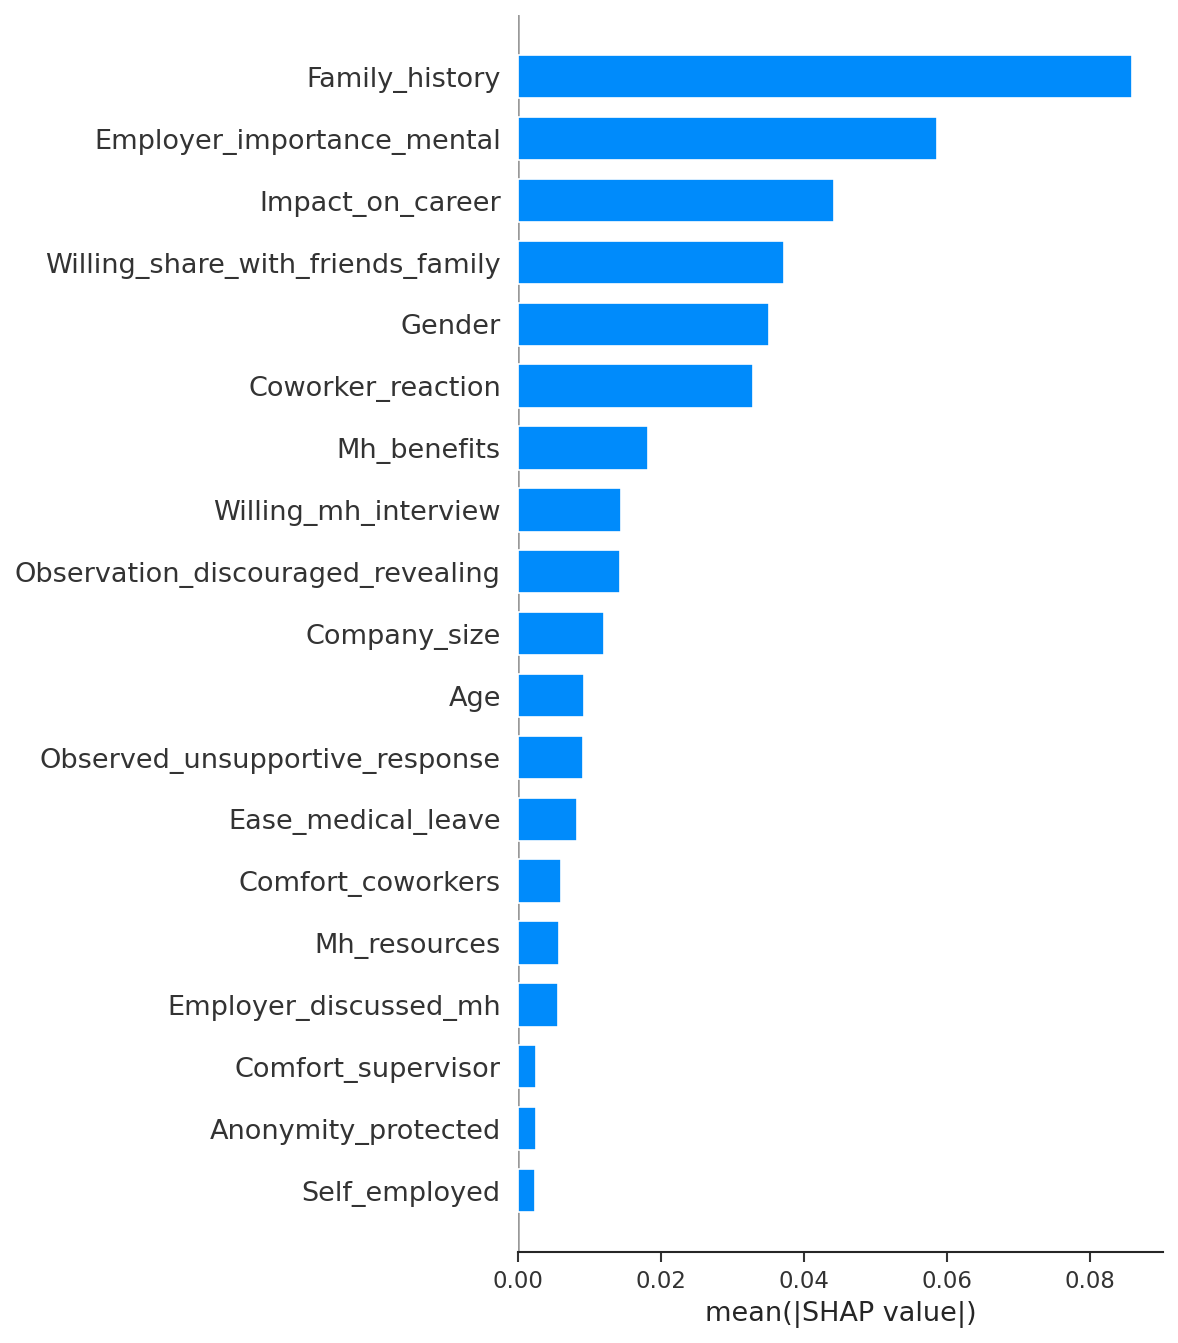

In [24]:
male_shap = shap_obj[male_mask]
female_shap = shap_obj[female_mask]

# --- PLOT FOR MALES ---
plt.figure(figsize=(10, 6))
shap.summary_plot(
    male_shap,
    X_test[male_mask],
    plot_type="bar",
    show=False
)

print("Top Global Predictors: Male Respondents\n(Mean Absolute SHAP Value)")

plt.xlabel("mean(|SHAP value|)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_bar_male.pdf"))
plt.show()

# --- PLOT FOR FEMALES ---
plt.figure(figsize=(10, 6))
shap.summary_plot(
    female_shap,
    X_test[female_mask],
    plot_type="bar",
    show=False
)

print("Top Global Predictors: Female Respondents\n(Mean Absolute SHAP Value)")

plt.xlabel("mean(|SHAP value|)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_bar_female.pdf"))
plt.show()

### **SHAP Waterfall**

Waterfall Analysis: Respondent 10


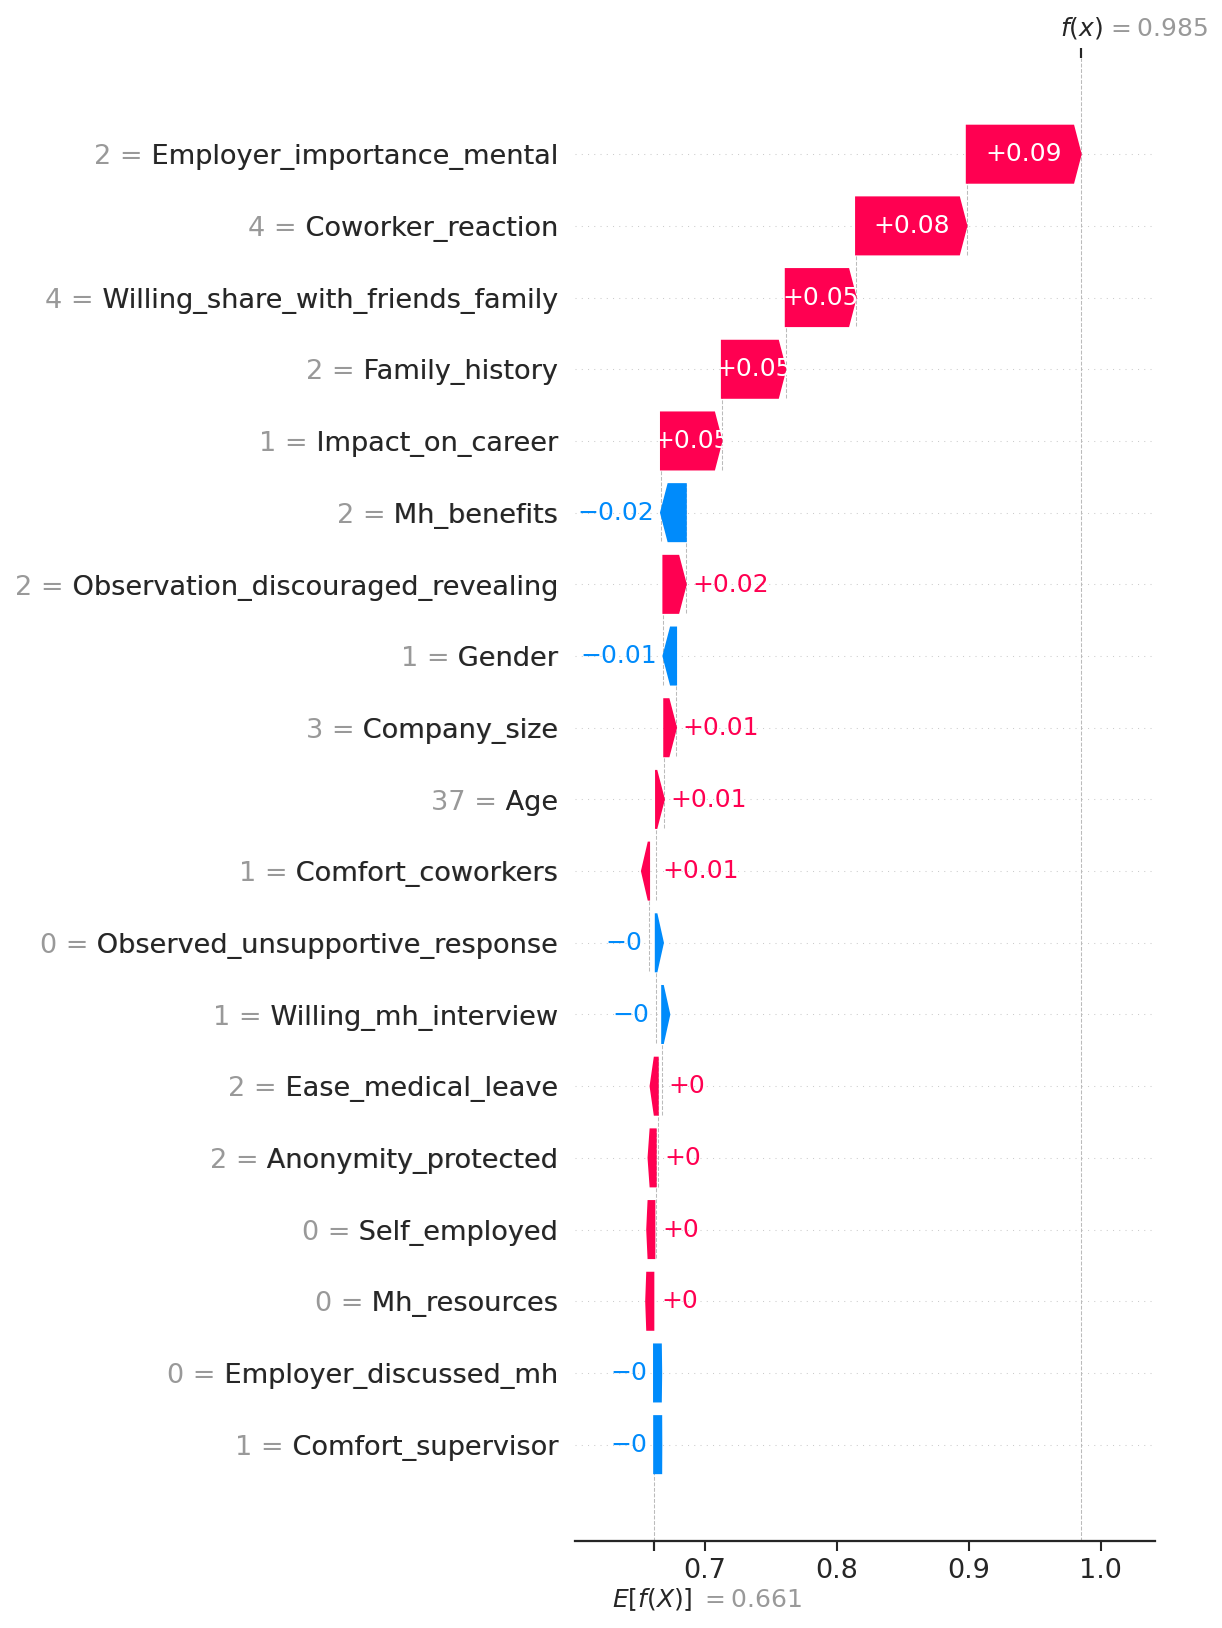

In [25]:
explanation_obj = explainer(X_test)

plt.figure(figsize=(10, 6))
shap.plots.waterfall(explanation_obj[10, :, 1], max_display=19, show=False)

print(f"Waterfall Analysis: Respondent 10")
plt.tight_layout()

plt.savefig(os.path.join(out_dir, "shap_waterfall_respondent_10.pdf"), bbox_inches='tight')
plt.show()

In [26]:
# Identify the respondent
respondent_idx = 10
actual_label = y_test.iloc[respondent_idx]
predicted_label = best_rf.predict(X_test.iloc[[respondent_idx]])[0]
gender_val = X_test.iloc[respondent_idx]['Gender']

gender_str = "Male" if gender_val == 1 else "Female"
status_str = "Diagnosed" if actual_label == 1 else "Not Diagnosed"
pred_str = "Diagnosed" if predicted_label == 1 else "Not Diagnosed"

print(f"--- Profile for Respondent Index {respondent_idx} ---")
print(f"Gender: {gender_str}")
print(f"Actual Status: {status_str}")
print(f"Model Prediction: {pred_str}")
print(f"Result: {'Correct' if actual_label == predicted_label else 'Incorrect'}")
print("\n--- Top Feature Values for this Person ---")
print(X_test.iloc[respondent_idx])

--- Profile for Respondent Index 10 ---
Gender: Male
Actual Status: Diagnosed
Model Prediction: Diagnosed
Result: Correct

--- Top Feature Values for this Person ---
Age                                  37
Gender                                1
Self_employed                         0
Company_size                          3
Mh_benefits                           2
Employer_discussed_mh                 0
Mh_resources                          0
Anonymity_protected                   2
Ease_medical_leave                    2
Comfort_coworkers                     1
Comfort_supervisor                    1
Employer_importance_mental            2
Family_history                        2
Coworker_reaction                     4
Willing_share_with_friends_family     4
Willing_mh_interview                  1
Impact_on_career                      1
Observed_unsupportive_response        0
Observation_discouraged_revealing     2
Name: 1580, dtype: int64


Waterfall Analysis: Respondent 11


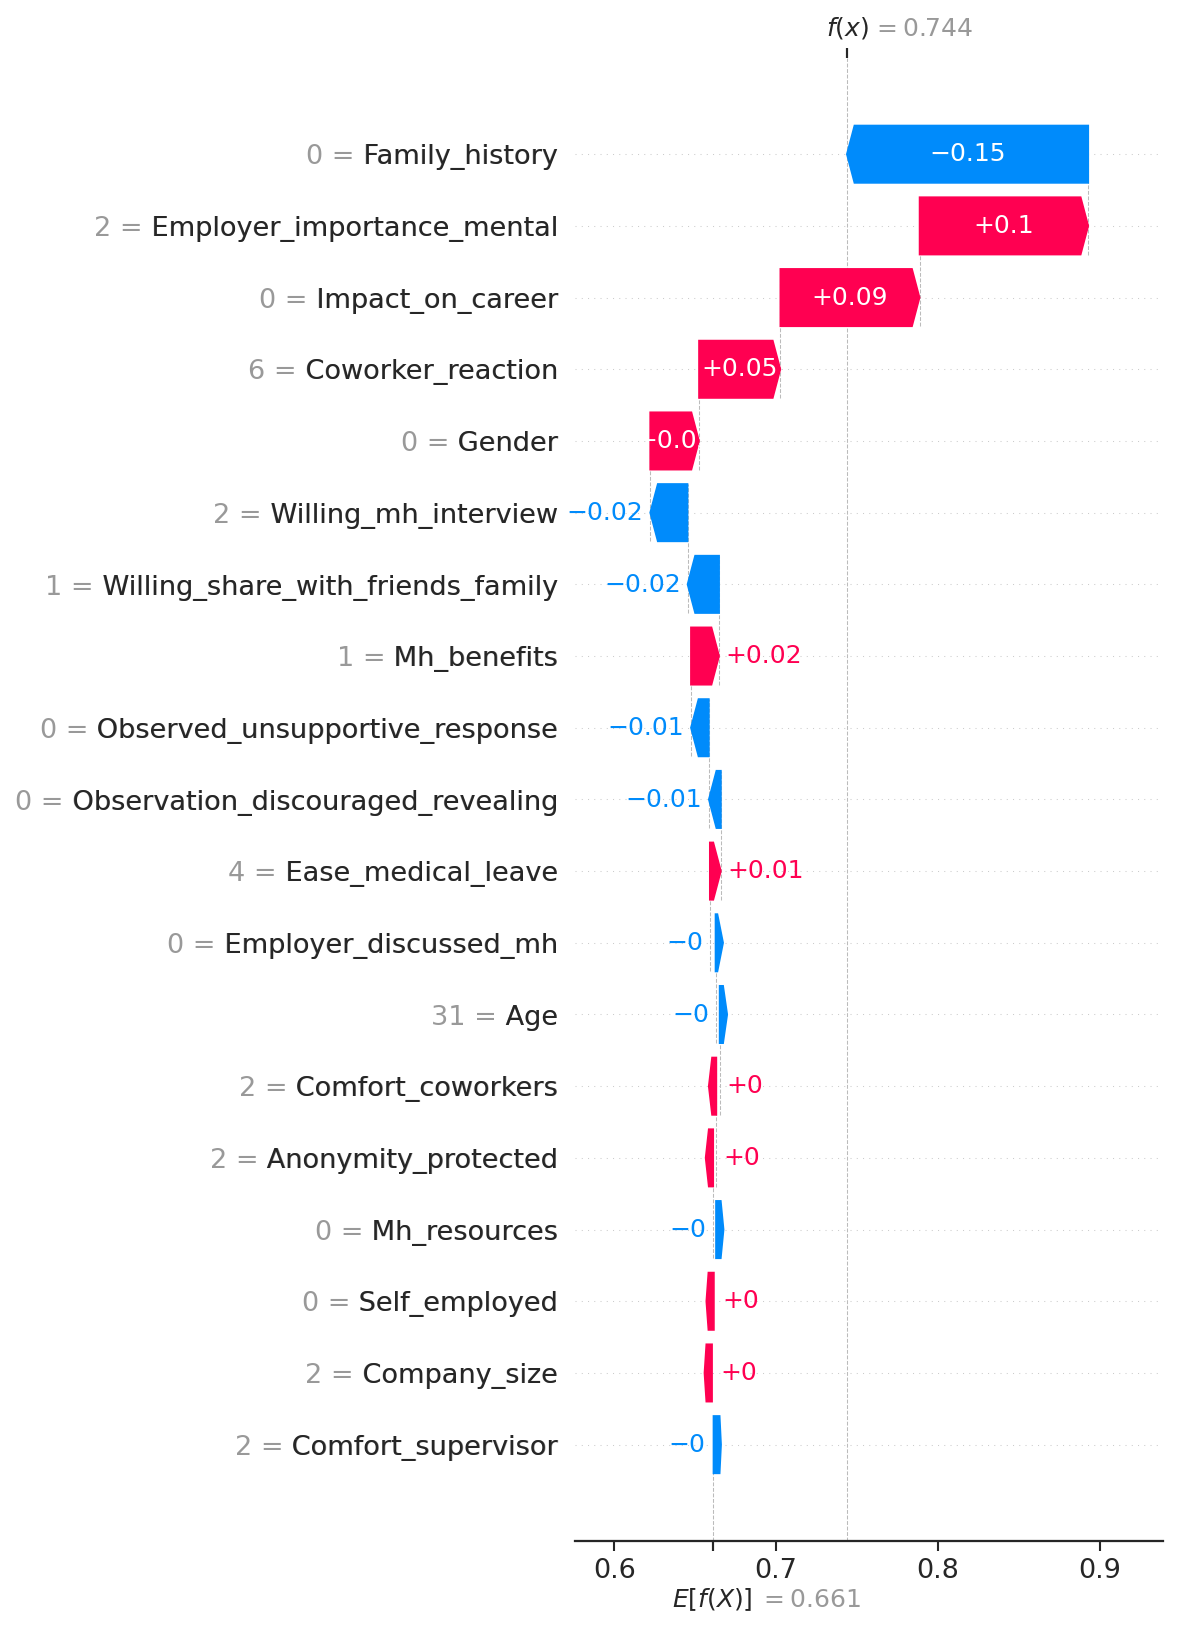

In [27]:
explanation_obj = explainer(X_test)

plt.figure(figsize=(10, 6))

shap.plots.waterfall(explanation_obj[11, :, 1], max_display=19, show=False)

print(f"Waterfall Analysis: Respondent 11")
plt.tight_layout()

plt.savefig(os.path.join(out_dir, "shap_waterfall_respondent_11.pdf"), bbox_inches='tight')
plt.show()

In [28]:
# Identify the respondent
respondent_idx = 11
actual_label = y_test.iloc[respondent_idx]
predicted_label = best_rf.predict(X_test.iloc[[respondent_idx]])[0]
gender_val = X_test.iloc[respondent_idx]['Gender']

gender_str = "Male" if gender_val == 1 else "Female"
status_str = "Diagnosed" if actual_label == 1 else "Not Diagnosed"
pred_str = "Diagnosed" if predicted_label == 1 else "Not Diagnosed"

print(f"--- Profile for Respondent Index {respondent_idx} ---")
print(f"Gender: {gender_str}")
print(f"Actual Status: {status_str}")
print(f"Model Prediction: {pred_str}")
print(f"Result: {'Correct' if actual_label == predicted_label else 'Incorrect'}")
print("\n--- Top Feature Values for this Person ---")
print(X_test.iloc[respondent_idx])

--- Profile for Respondent Index 11 ---
Gender: Female
Actual Status: Diagnosed
Model Prediction: Diagnosed
Result: Correct

--- Top Feature Values for this Person ---
Age                                  31
Gender                                0
Self_employed                         0
Company_size                          2
Mh_benefits                           1
Employer_discussed_mh                 0
Mh_resources                          0
Anonymity_protected                   2
Ease_medical_leave                    4
Comfort_coworkers                     2
Comfort_supervisor                    2
Employer_importance_mental            2
Family_history                        0
Coworker_reaction                     6
Willing_share_with_friends_family     1
Willing_mh_interview                  2
Impact_on_career                      0
Observed_unsupportive_response        0
Observation_discouraged_revealing     0
Name: 2102, dtype: int64
